# Trabalho 2 - Sentimentos em Comentários da Google Play Store

Alunos:
- Gabriel Pires da Cruz - (Redes Neurais)
- Isabela Acosta Rodrigues - (SVM)
- Taiana Faleiro dos Santos - (Árvores de Decisão)
- Wagner Spinato Chitto (Regressão Logística)

# 1 - Introdução

[Colocar aqui blá blá blá de introdução]

# 2 - Importação e Análise dos Dados para Treino

In [ ]:
# Importação dos dados de treino do .csv fornecido pelo professor
import pandas as pd
df_reviews = pd.read_csv('apps_reviews.csv')

# Dropar colunas desnecessárias
df_reviews.drop(columns=['reviewId', 'app_name', 'Unnamed: 5'], inplace=True)

# head
df_reviews.head(10)

,content,sentiment_polarity,sentiment
0,O app da Shopee é razoável. Apesar de ser fáci...,positive,sadness
1,"O app é bem otimizado, fácil de visualizar os ...",positive,sadness
2,"O app é muito bom, prático e fácil de entender...",positive,sadness
3,Aplicativo muito bom. Mas algo que me chateou ...,positive,sadness
4,"o app é muito bom, porém tenho tido dificuldad...",negative,disgust
5,"É muito bom esse app, porém ele fica travando ...",positive,happiness
6,Tenho gostado bastante do app. Acredito que em...,positive,happiness
7,"Adoro, tudo que você pensar tem e as promoções...",positive,happiness
8,"O app é muito bom,algumas mercadorias são real...",positive,sadness
9,Estava com problema inicial de não conseguir e...,negative,anger


In [ ]:
# Limpeza dos dados
# É importante caso exista alguns valores inválidos
df_reviews.dropna(inplace=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3011 entries, 0 to 3010
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   content             3011 non-null   object
 1   sentiment_polarity  3011 non-null   object
 2   sentiment           3011 non-null   object
dtypes: object(3)
memory usage: 70.7+ KB


# 3 - Pré-processamento
Algumas etapas serão realizadas:
- Limpeza
  - Converter todo o texto para minúsculas
  - Remover caracteres especiais, pontuações, números, emojis, etc
  - Remover stopwords -- que são palavras que não agregam significado ao texto (o, a, de, etc).
  
- Tokenização
- Stemming
- Padronização

## 3.1 - Preparação e download das ferramentas necessárias
NTLK e coisa e tal......

In [ ]:
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from collections import Counter
import itertools

# Baixar recursos necessários do NLTK
# punkt: para tokenização de sentenças e palavras
# stopwords: lista de palavras comuns a serem removidas
# rslp: stemmer para português
# wordnet: dicionário para lematização (principalmente inglês)
# averaged_perceptron_tagger: para POS tagging (usado na lematização)

print("Verificando e baixando recursos NLTK...")

nltk_resources = ['punkt', 'stopwords', 'rslp', 'wordnet', 'averaged_perceptron_tagger']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}' if resource in ['stopwords', 'wordnet'] else f'stemmers/{resource}' if resource == 'rslp' else f'taggers/{resource}')
        print(f"Recurso '{resource}' já baixado.")
    except LookupError:
         print(f"Recurso '{resource}' não encontrado localmente. Baixando...")
         nltk.download(resource)


print("Verificação e download de recursos NLTK concluídos!")

# Carregar stop words do NLTK e stemmer (para uso posterior)
stop_words_portugues = set(stopwords.words('portuguese'))
stemmer_portugues = RSLPStemmer()

Verificando e baixando recursos NLTK...
Recurso 'punkt' já baixado.
Recurso 'stopwords' já baixado.
Recurso 'rslp' já baixado.
Recurso 'wordnet' não encontrado localmente. Baixando...
Recurso 'averaged_perceptron_tagger' já baixado.
Verificação e download de recursos NLTK concluídos!


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Importar biblioteca para funções de emoji
!pip install emoji
import emoji

## 3.2 - Limpeza

In [ ]:
# Converter todos os comentários para letras minúsculas
df_reviews['content'] = df_reviews['content'].str.lower()

# Remover todas as pontuações
df_reviews['content'] = df_reviews['content'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remover todos os números
df_reviews['content'] = df_reviews['content'].apply(lambda x: re.sub(r'\d+', '', x))


# Remover espaços em branco extras
df_reviews['content'] = df_reviews['content'].apply(lambda x: ' '.join(x.split()))

In [ ]:
# Remover stopwords (palavras de parada)
df_reviews['content'] = df_reviews['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words_portugues]))

# Remover emojis e substituir por palavras
# O argumento language='pt' garante que os emojis sejam substituidos por palavras em português
# Como por exemplo  ❤️ -> :coração_vermelho:
df_reviews['content'] = df_reviews['content'].apply(lambda x: emoji.demojize(x, language='pt'))

df_reviews.head(10)

,content,sentiment_polarity,sentiment
0,app shopee razoável apesar fácil utilizar apre...,positive,sadness
1,app bem otimizado fácil visualizar produtos pe...,positive,sadness
2,app bom prático fácil entender porém alguns ve...,positive,sadness
3,aplicativo bom algo chateou bastante fato pesq...,positive,sadness
4,app bom porém tido dificuldades pagamento cart...,negative,disgust
5,bom app porém fica travando pouco hora conclui...,positive,happiness
6,gostado bastante app acredito decorrência atua...,positive,happiness
7,adoro tudo pensar promoções frete diferencial ...,positive,happiness
8,app bomalgumas mercadorias realmente qualidade...,positive,sadness
9,problema inicial conseguir enviar mensagens ch...,negative,anger


## 3.3 Tokenização

Blá blá blá sobre tokenização

In [ ]:
# Baixando recursos para tokenização
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Tokenização das avaliações de aplicativos
df_reviews['content'] = df_reviews['content'].apply(lambda x: word_tokenize(x))

df_reviews.head(10)

,content,sentiment_polarity,sentiment
0,"[app, shopee, razoável, apesar, fácil, utiliza...",positive,sadness
1,"[app, bem, otimizado, fácil, visualizar, produ...",positive,sadness
2,"[app, bom, prático, fácil, entender, porém, al...",positive,sadness
3,"[aplicativo, bom, algo, chateou, bastante, fat...",positive,sadness
4,"[app, bom, porém, tido, dificuldades, pagament...",negative,disgust
5,"[bom, app, porém, fica, travando, pouco, hora,...",positive,happiness
6,"[gostado, bastante, app, acredito, decorrência...",positive,happiness
7,"[adoro, tudo, pensar, promoções, frete, difere...",positive,happiness
8,"[app, bomalgumas, mercadorias, realmente, qual...",positive,sadness
9,"[problema, inicial, conseguir, enviar, mensage...",negative,anger


## 3.4 Lematização

Bla bla bla sobre lematização

In [ ]:
# Instalando a biblioteca spacy
import spacy
!python -m spacy download pt_core_news_sm
# Load the Portuguese language model
nlp = spacy.load('pt_core_news_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Função para lematizar uma lista de tokens
def lematizar_lista_tokens(lista_de_palavras):
    """
    Recebe uma lista de palavras e retorna uma lista de lemas.
    """
    # Junta a lista em uma string para o spaCy processar com contexto
    texto = " ".join(lista_de_palavras)

    # Processa o texto com o spaCy
    doc = nlp(texto)

    # Retorna a lista de lemas
    lemas = [token.lemma_ for token in doc]
    return lemas

In [ ]:
df_reviews['content'] = df_reviews['content'].apply(lematizar_lista_tokens)

In [ ]:
df_reviews.head(10)

,content,sentiment_polarity,sentiment
0,"[app, shopee, razoável, apesar, fácil, utiliza...",positive,sadness
1,"[appr, bem, otimizar, fácil, visualizar, produ...",positive,sadness
2,"[app, bom, prático, fácil, entender, porém, al...",positive,sadness
3,"[aplicativo, bom, algo, chatear, bastante, fat...",positive,sadness
4,"[app, bom, porém, ter, dificuldade, pagamento,...",negative,disgust
5,"[bom, app, porém, ficar, travar, pouco, hora, ...",positive,happiness
6,"[gostar, bastante, app, acreditar, decorrência...",positive,happiness
7,"[adorar, tudo, pensar, promoção, frete, difere...",positive,happiness
8,"[App, bomalguma, mercadoria, realmente, qualid...",positive,sadness
9,"[problema, inicial, conseguir, enviar, mensage...",negative,anger


# 4 - Representação Textual e Engenharia de Features

Vamos transformar o texto pré-processado em vetores numéricos para que os modelos de aprendizado de máquina consigam processar.

Usaremos 4 métodos diferentes para representação em vetores numéricos:

- **Bag of Words (BoW)** : Representação por frequência de palavras
- **TF-IDF (Term Frequency-Inverse Document Frequency)** : Representa o texto pela importância de cada palavra no documento em relação ao corpus inteiro.
- **Word2Vec** : Cria vetores de palavras densos que capturam relações semânticas entre elas.
- **BERTimbau** : Um modelo de linguagem pré-treinado para o português.

## 4.1 - Word2Vec

In [ ]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
# Word2VEC

import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Baixar todos os recursos necessários para NLTK
# Isso pode levar um tempo e baixar muitos dados
nltk.download('all') # Uncommenting this line would download all resources

# Assegurando que o recurso 'punkt' está disponível
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Assegurando que o recurso 'punkt_tab' está disponível
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

## 4.2 - Bag of Words (BoW)

Código para representação usando BoW vai aqui embaixo

In [ ]:
# Códigos para BoW....
#
#
#
#

## 4.3 - TF-IDF

Código para representação usando TF-IDF aqui embaixo

In [ ]:
# Códigos para TF-IDF
#
#
#
#

## 4.4 - BERTimbau

Códigos para BERTimbau vai aqui embaixo

In [ ]:
# Códigos para BERTimbau
#
#
#
#
#
#


# 5 - Treinamento e Avaliação dos Modelos de Aprendizado de Máquina

Para cada representação textual (BoW, TF-IDF, Word2Vec e BERTimbau) das avaliações de aplicativos, aplicaremos quatro modelos de aprendizado de máquina para classificar o sentimento e a polaridade de cada avaliação feita pelos usuários.

## 5.1 -Treinamento dos modelos utilizando Word2Vec

### 5.1.1 - SVM utilizando Word2Vec (Isabela)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_reviews = pd.read_csv('apps_reviews.csv')
X = df_reviews.drop(columns=['sentiment_polarity', 'sentiment', 'reviewId', 'app_name', 'Unnamed: 5']) # Dropp colunas
y = df_reviews['sentiment'] # Or 'sentiment_polarity'

X,y = train_test_split(return_X_y = True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2017, 1)
Shape of X_test: (994, 1)
Shape of y_train: (2017,)
Shape of y_test: (994,)


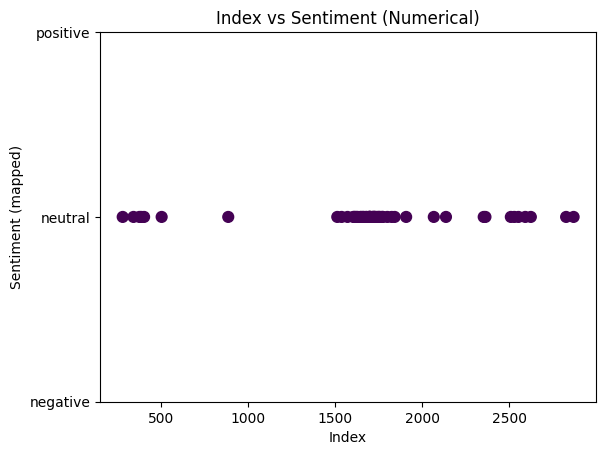

In [ ]:
import matplotlib.pyplot as plt

sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
y_train_numeric = y_train.map(sentiment_map)

fig, ax = plt.subplots()
ax.scatter(X_train.index, y_train_numeric, c=y_train_numeric, cmap='viridis', s=60)

ax.set_xlabel('Index')
ax.set_ylabel('Sentiment (mapped)')
ax.set_title('Index vs Sentiment (Numerical)')

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['negative', 'neutral', 'positive'])

plt.show()


In [ ]:
# Agora que os dados foram pré-processados e vetorizados, podemos treinar o modelo SVM.
#
#

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize TfidfVectorizer
# You can adjust parameters like max_features, ngram_range, etc.
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Example: consider the top 5000 features

# Fit the vectorizer on the training data and transform both training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['content'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['content'])

print("Shape of X_train after TF-IDF:", X_train_tfidf.shape)
print("Shape of X_test after TF-IDF:", X_test_tfidf.shape)

# Initialize the SVM classifier
# Using a linear kernel, which often works well with text data
svm_clf = SVC(kernel='linear')

# Train the SVM model
svm_clf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_clf.predict(X_test_tfidf)

# Evaluate the model
print("\nSVM Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### 5.1.2 - Árvores de decisão utilizando Word2Vec (Taiana)

### 5.1.3 - Regressão Logística utilizando Word2Vec (Wagner)

### 5.1.4 - Redes Neurais utilizando Word2Vec (Gabriel)

## 5.2 - Treinamento dos Modelos Utilizando Bag of Words (BoW)

### 5.2.1 - SVM utilizando BoW (Isabela)

### 5.2.2 - Árvores de Decisão utilizando BoW (Taiana)

### 5.2.3 - Regressão Logística utilizando BoW (Wagner)

### 5.2.4 - Redes Neurais utilizando BoW (Gabriel)

## 5.3 - Treinamento dos Modelos Utilizando TF-IDF

### 5.3.1 - SVM utilizanfo TF-IDF (Isabela)

### 5.3.2 - Árvores de Decisão utilizanfo TF-IDF (Taiana)

### 5.3.3 - Regressão Logística utilizanfo TF-IDF (Wagner)

### 5.3.4 - Redes Neurais utilizando TF-IDF (Gabriel)

## 5.4 - Treinamento de Modelos utilizando BERTimbau

### 5.4.1 - SVM utilizando BERTimbau (Isabela)

### 5.4.2 - Árvores de Decisão utilizando BERTimbau (Taiana)

### 5.4.3 - Regressão Logística utilizando BERTimbau (Wagner)

### 5.4.4 - Redes Neurais utilizando BERTimbau (Gabriel)